In [14]:
import pandas as pd
from pandas import DataFrame
import numpy as np 

In [15]:
price_data = pd.read_csv("sample_data/prices_round_1_day_-2.csv", sep=";")
print(price_data.head())
print(price_data.shape)
print(price_data[:500])
pd.set_option('display.max_rows', None)

   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  AMETHYSTS         9996             1       9995.0   
1   -2          0  STARFRUIT         4997            26          NaN   
2   -2        100  AMETHYSTS        10000             5       9995.0   
3   -2        100  STARFRUIT         5000             5       4998.0   
4   -2        200  STARFRUIT         4997             1       4996.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          25.0          NaN           NaN        10004             1   
1           NaN          NaN           NaN         5003            26   
2          20.0          NaN           NaN        10005            20   
3           6.0       4997.0          20.0         5004            20   
4          30.0          NaN           NaN         5003            31   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0      10005.0          25.0          NaN           NaN   

## Trading Algorithms 
1. condense the prices data from round_1 starting from day -2 to -1 to 0 
2. aggregate the trades data from round_1  
3. Write trading strategies starting with basic directionality long/short predictions: pairs trading with stationarity/ cointegration (ARIMA?), mean reversion, momentum, volalitilty, etc.
    - start with algorithmic trading on the mid_price data only (to predict the true value of the actual price)
    - Then consider how to factor in individual order sizes from other market traders for both buy and sell orders, paying special attention to the volume of the orders in addition to the price 
4. backtest and implement calculations unrealized PNL and total PNL
5. Then augment with position sizing calculus for algorithms that show promise
    - One idea is to incorporate volume/volatility based calculations in position sizing 

### Step 1
Aggregate price data

In [16]:
price_data = pd.concat([pd.read_csv("sample_data/prices_round_1_day_-2.csv", sep=";"), pd.read_csv("sample_data/prices_round_1_day_-1.csv", sep=";"),pd.read_csv("sample_data/prices_round_1_day_0.csv", sep=";")], ignore_index=True)

print(price_data.shape)

(60000, 17)


In [17]:
import matplotlib.pyplot as plt

# graph the price data for all the days
def plot_price_data_per_product(product1 :str, product2 :str, df :DataFrame, y_range_product1=None, y_range_product2=None):
    """
    Plots the price data per product by their mid_price. Uses row index as x-axis, and assumes the existence of a mid_price per product
    - products: the str value of the products
    - df: the dataframe data
    """
    product1_data = df[df['product'] == product1]
    product2_data =df[df['product'] == product2]

    fig, ax1 = plt.subplots(figsize=(12, 8))

    color = 'tab:blue'
    ax1.set_xlabel('Index')
    ax1.set_ylabel(f'{product1} Price', color=color)
    ax1.set
    ax1.plot(product1_data.index / 2, product1_data['mid_price'], label=f"{product1}_Mid_Price", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False, style='plain')
    if y_range_product1:
        ax1.set_ylim(y_range_product1)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel(f'{product2} Price', color=color)  # we already handled the x-label with ax1
    ax2.plot(product2_data.index / 2, product2_data['mid_price'], label=f"{product2}_Mid_Price", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.ticklabel_format(useOffset=False, style='plain')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.suptitle('Price Data Comparison', fontsize=16, y=1.02)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

    """
    plt.figure(figsize=(12, 8))
    plt.plot(product1_data.index / 2, product1_data['mid_price'], label=f"{product1}_Mid_Price", color="blue")    
    plt.plot(product2_data.index / 2, product2_data['mid_price'], label=f"{product2}_Mid_Price", color="orange")

    plt.ticklabel_format(useOffset=False, style='plain')

    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title('Price_Data')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

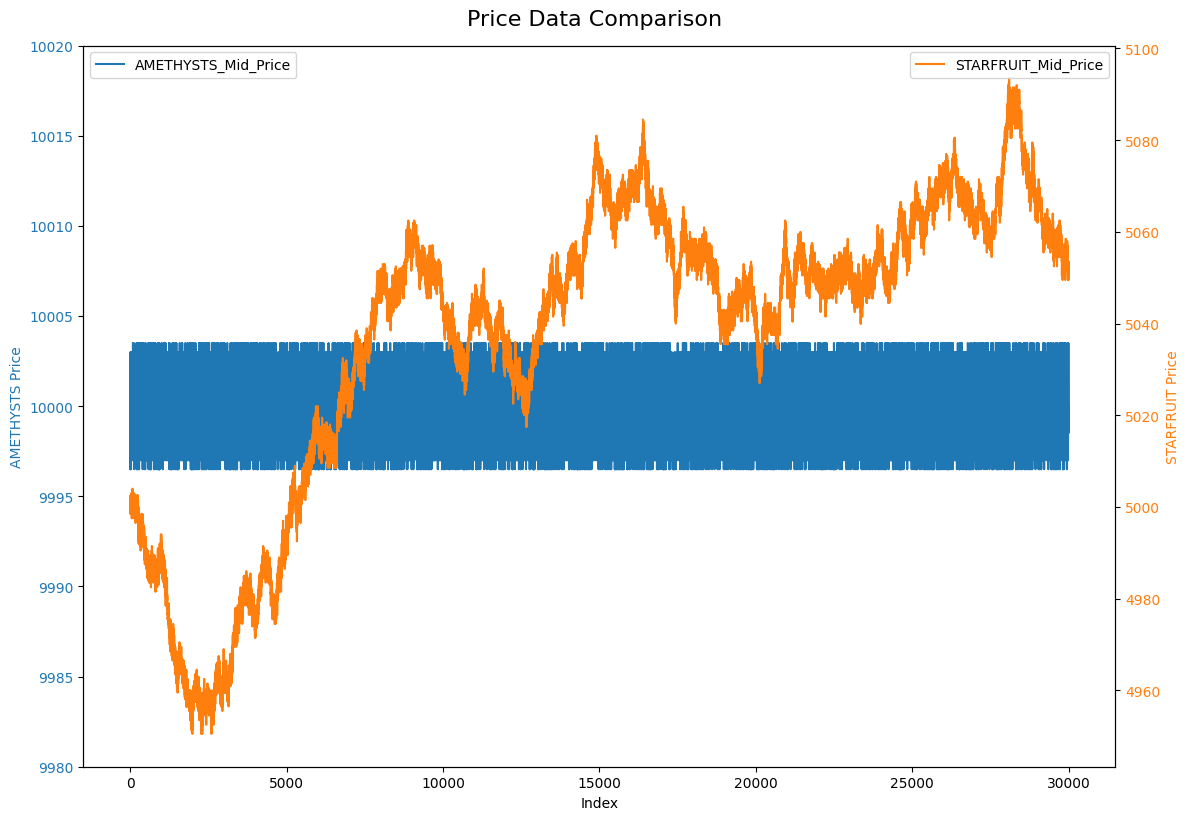

In [18]:
plot_price_data_per_product("AMETHYSTS","STARFRUIT", price_data, [9980,10020])

### Simple vs Exponential Moving Average


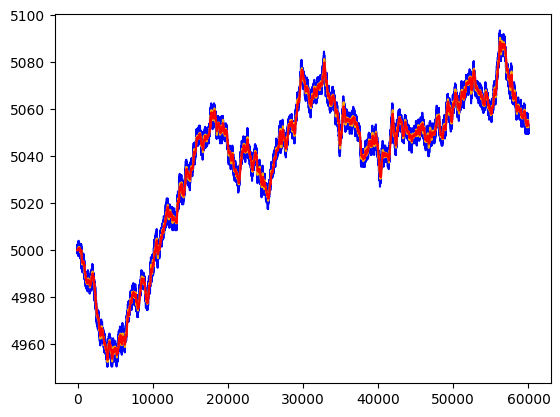

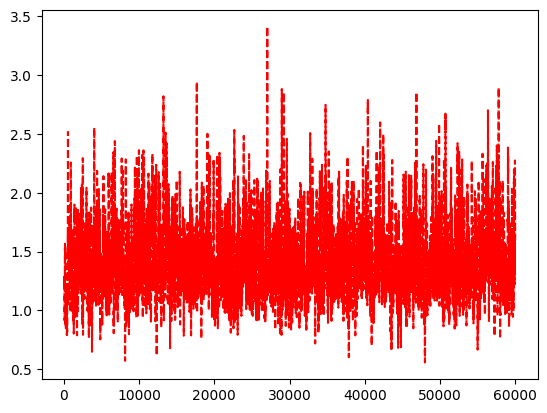

       mid_price  mid_price
1    5000.000000        NaN
3    5000.064516        NaN
4    5000.062435        NaN
7    5000.044292        NaN
9    4999.994476        NaN
11   5000.059170        NaN
12   5000.041133        NaN
15   5000.039806        NaN
17   5000.119167        NaN
19   5000.195968        NaN
20   5000.157388        NaN
22   5000.136182        NaN
25   5000.131789        NaN
26   5000.192054        NaN
28   5000.137472        NaN
30   5000.133037        NaN
33   5000.128746        NaN
34   5000.108464        NaN
36   5000.056578        NaN
38   5000.135398        NaN
41   5000.082643        NaN
42   5000.144493        NaN
44   5000.139832        NaN
46   5000.135321        NaN
49   5000.147085        NaN
50   5000.126211        NaN
52   5000.138269        NaN
54   5000.149938        NaN
57   5000.161230        NaN
58   5000.139900   1.250862
60   5000.103129   1.270917
62   5000.164319   1.270917
65   5000.142889   1.277120
66   5000.138280   1.270917
68   5000.149948   1

In [19]:
starfruit = price_data[price_data['product'] == "STARFRUIT"]
starfruit_sma_30 = starfruit['mid_price'].rolling(30).mean()

starfruit_ema_30 = starfruit['mid_price'].ewm(30, adjust=False).mean()
starfruit_ema_30_std = starfruit['mid_price'].rolling(30).std()

plt.plot(starfruit['mid_price'], color="blue")
plt.plot(starfruit_sma_30, color="orange")
plt.plot(starfruit_ema_30, color="red")
plt.show()

plt.plot(starfruit_ema_30_std, linestyle="--", color="red")
plt.show()

df = pd.concat([starfruit_ema_30,starfruit_ema_30_std],axis=1)
print(df[:300])

(30000,)
Index([    1,     3,     4,     7,     9,    11,    12,    15,    17,    19,
       ...
       59980, 59982, 59984, 59987, 59988, 59990, 59992, 59995, 59996, 59998],
      dtype='int64', length=30000)


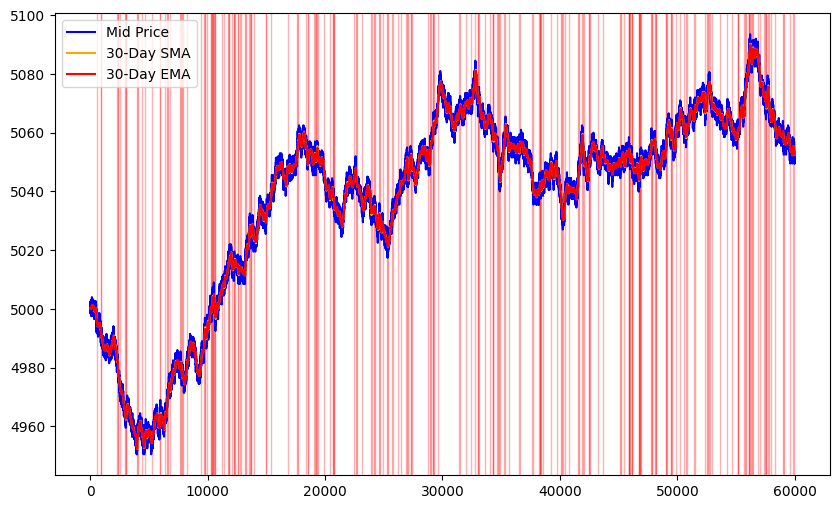

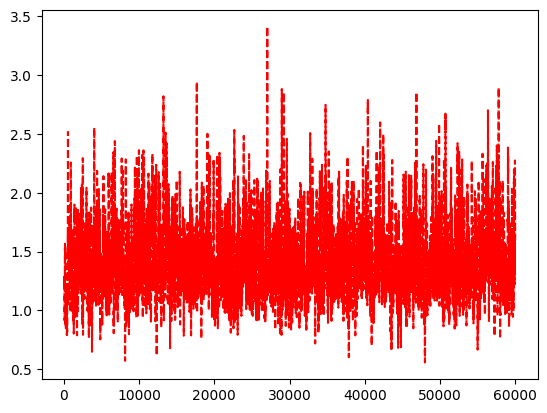

In [24]:
# Your initial setup
starfruit = price_data[price_data['product'] == "STARFRUIT"]
starfruit_sma_30 = starfruit['mid_price'].rolling(30).mean()
starfruit_ema_30 = starfruit['mid_price'].ewm(span=30, adjust=False).mean()
starfruit_ema_30_std = starfruit['mid_price'].rolling(30).std()

# First plot
plt.figure(figsize=(10, 6))
plt.plot(starfruit['mid_price'], color="blue", label='Mid Price')
plt.plot(starfruit_sma_30, color="orange", label='30-Day SMA')
plt.plot(starfruit_ema_30, color="red", label='30-Day EMA')

# Find indices where volatility is greater than 1.5
high_vol_indices = starfruit_ema_30_std > 2
print(high_vol_indices.shape)
print(high_vol_indices.index)

start_holding = None
end_holding = None
for idx in high_vol_indices.index:
    if high_vol_indices[idx] == True:
        if not start_holding:
            start_holding = idx
    else:
        if start_holding:
            end_holding = idx
            # Plot the holding period in red overlay
            plt.axvspan(start_holding, end_holding, color='red', alpha=0.3)

            start_holding = None
            end_holding = None


plt.legend()
plt.show()

plt.plot(starfruit_ema_30_std, linestyle="--", color="red")
plt.show()

In [21]:
def calculate_linear_reg(starfruit):
            """Runs a least squares linear regression through the price data in the self.rolling_periods timeframe"""
            starfruit_prices = starfruit['mid_price']
            y_vals = np.array(starfruit_prices)
            x_vals = np.arange(0,len(starfruit_prices))
            x_mean = np.mean(x_vals)
            y_mean = np.mean(y_vals)
            slope = np.sum((x_vals - x_mean) * (y_vals - y_mean)) / np.sum((x_vals - x_mean)**2)
            b = y_mean - slope * x_mean

            # Predict y values
            y_pred = slope * x_vals + b

            return y_pred, slope, b

-0.03387038703870387


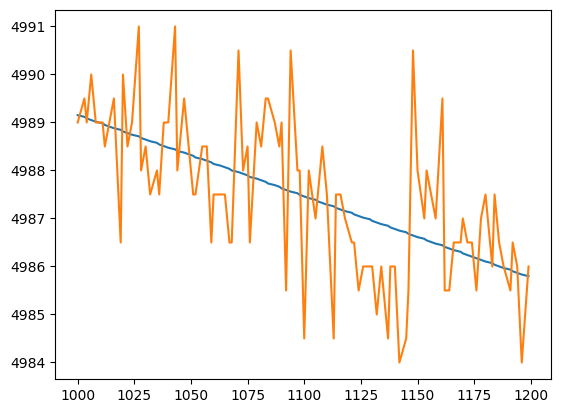

In [22]:
y_pred, slope, _ = calculate_linear_reg(starfruit[500:600])
print(slope)
plt.plot(starfruit[500:600]["mid_price"].index, y_pred)
plt.plot(starfruit[500:600]["mid_price"])
plt.show()

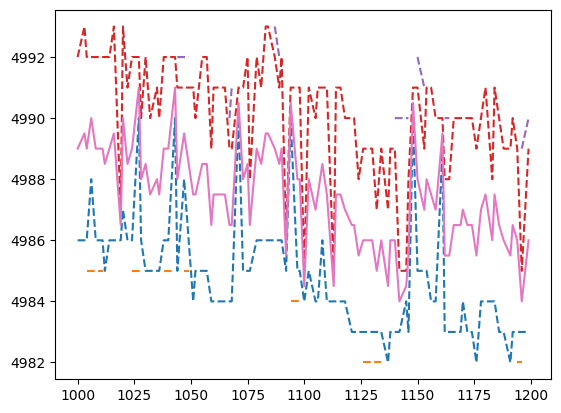

In [23]:
starfruit_1 = starfruit[500:600]

### plot the ask/bids for each trader 
bid_1 = starfruit_1['bid_price_1']
bid_2 = starfruit_1['bid_price_2']
bid_3 = starfruit_1['bid_price_3']

ask_1 = starfruit_1['ask_price_1']
ask_2 = starfruit_1['ask_price_2']
ask_3 = starfruit_1['ask_price_3']

plt.plot(bid_1, linestyle="--")
plt.plot(bid_2, linestyle="--")
plt.plot(bid_3,  linestyle="--")

plt.plot(ask_1,  linestyle="--")
plt.plot(ask_2, linestyle="--")
plt.plot(ask_3, linestyle="--")

plt.plot(starfruit_1['mid_price'])

plt.show()


### Step 2
Aggregate and analyze Trade data

In [20]:
"""trades_data = pd.concat([pd.read_csv("sample_data/trades_round_1_day_-2_nn.csv", sep=";"), pd.read_csv("sample_data/trades_round_1_day_-1_nn.csv", sep=";"),pd.read_csv("sample_data/trades_round_1_day_0_nn.csv", sep=";")], ignore_index=True)"""

files = [
    "sample_data/trades_round_1_day_-2_nn.csv",
    "sample_data/trades_round_1_day_-1_nn.csv",
    "sample_data/trades_round_1_day_0_nn.csv"
]

dataframes = [pd.read_csv(file, sep=";") for file in files]

# Initialize a variable to keep track of the cumulative maximum timestamp
cumulative_max_timestamp = 0

# Adjust the timestamps
for df in dataframes:
    df['timestamp'] += cumulative_max_timestamp  # Adjust the timestamp
    cumulative_max_timestamp = df['timestamp'].max()  # Update the cumulative max

# Concatenate the adjusted DataFrames
trades_data = pd.concat(dataframes, ignore_index=True)


print(trades_data.shape)
print(trades_data.head())
print(trades_data)

(16150, 7)
   timestamp  buyer  seller     symbol   currency   price  quantity
0          0    NaN     NaN  AMETHYSTS  SEASHELLS  9996.0         1
1          0    NaN     NaN  STARFRUIT  SEASHELLS  5003.0         1
2          0    NaN     NaN  AMETHYSTS  SEASHELLS  9996.0         1
3        100    NaN     NaN  STARFRUIT  SEASHELLS  5004.0         6
4        900    NaN     NaN  STARFRUIT  SEASHELLS  5001.0         2
       timestamp  buyer  seller     symbol   currency    price  quantity
0              0    NaN     NaN  AMETHYSTS  SEASHELLS   9996.0         1
1              0    NaN     NaN  STARFRUIT  SEASHELLS   5003.0         1
2              0    NaN     NaN  AMETHYSTS  SEASHELLS   9996.0         1
3            100    NaN     NaN  STARFRUIT  SEASHELLS   5004.0         6
4            900    NaN     NaN  STARFRUIT  SEASHELLS   5001.0         2
5           1000    NaN     NaN  STARFRUIT  SEASHELLS   4997.0         2
6           1100    NaN     NaN  STARFRUIT  SEASHELLS   4997.0        

In [21]:
def plot_trades_per_product(product1: str, product2: str, df):
    # Filter the DataFrame for each product efficiently
    df_product1 = df.loc[df['symbol'] == product1, ['timestamp','price', 'quantity']]
    df_product2 = df.loc[df['symbol'] == product2, ['timestamp','price', 'quantity']]
    
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plotting product1 trades
    color_product1 = 'tab:blue'
    ax1.set_xlabel('Index')
    ax1.set_ylabel(f'{product1} Price', color=color_product1)
    ax1.scatter(df_product1['timestamp'], df_product1['price'], s=df_product1['quantity'], color=color_product1, alpha=0.5, label=f'{product1} Quantity')
    ax1.tick_params(axis='y', labelcolor=color_product1)
    ax1.ticklabel_format(useOffset=False, style='plain')

    # Creating a twin Axes sharing the xaxis
    ax2 = ax1.twinx()
    color_product2 = 'tab:orange'
    ax2.set_ylabel(f'{product2} Price', color=color_product2)
    ax2.scatter(df_product2['timestamp'], df_product2['price'], s=df_product2['quantity'], color=color_product2, alpha=0.5, label=f'{product2} Quantity')
    ax2.tick_params(axis='y', labelcolor=color_product2)
    ax2.ticklabel_format(useOffset=False, style='plain')
    
    # Additional plot adjustments
    fig.tight_layout()
    fig.suptitle('Trade Data Comparison', fontsize=16, y=1.02)

    plt.show()

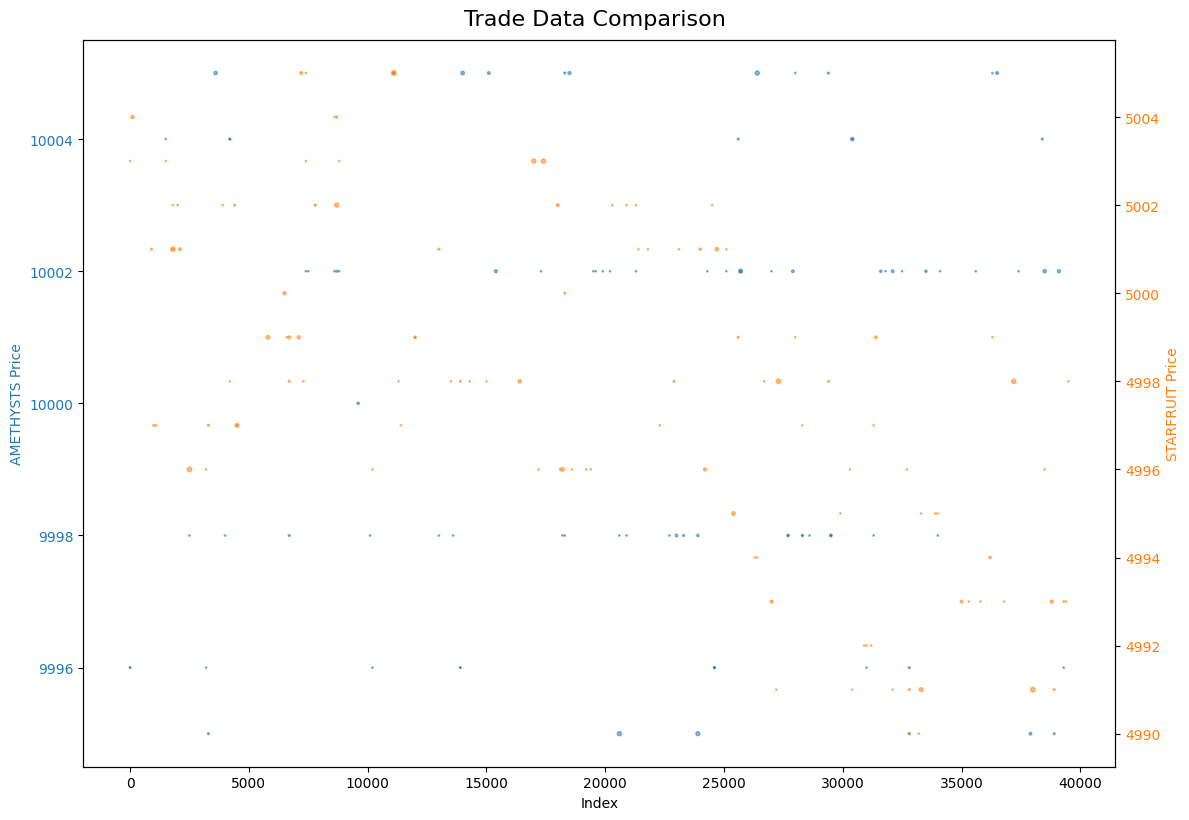

In [22]:
plot_trades_per_product("AMETHYSTS","STARFRUIT", trades_data[:200])

### Volume vs Price

In [23]:
def plot_trade_volume_vs_price(product, df):
    df_product = df.loc[df['symbol'] == product, ['timestamp','price', 'quantity']]

    # Group by 'timestamp' and 'symbol', then sum the 'quantity'
    aggregated_df = df_product.groupby(['timestamp', 'price']).agg({'quantity': 'sum'}).reset_index()

    # To view the aggregated DataFrame
    print(aggregated_df)
    print("Correlation: " + str(aggregated_df['price'].corr(aggregated_df['quantity'])))

    fig,ax1 = plt.subplots(figsize=(12, 8))

    color_product1 = 'tab:blue'
    ax1.set_xlabel('Index')
    ax1.set_ylabel(f'{product} Price', color=color_product1)
    ax1.plot(aggregated_df['price'], color=color_product1)
    ax1.tick_params(axis='y', labelcolor=color_product1)
    ax1.ticklabel_format(useOffset=False, style='plain')

    # Creating a twin Axes sharing the xaxis
    ax2 = ax1.twinx()
    color_product2 = 'tab:pink'
    ax2.set_ylabel(f'{product} Volume', color=color_product2)
    ax2.plot(aggregated_df['quantity'], color=color_product2)
    ax2.tick_params(axis='y', labelcolor=color_product2)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.set_ylim([0,50])
    
    # Additional plot adjustments
    fig.tight_layout()
    fig.suptitle('Volume to Trade Data Comparison', fontsize=16, y=1.02)

    plt.show()
        

     timestamp   price  quantity
0            0  5003.0         1
1          100  5004.0         6
2          900  5001.0         2
3         1000  4997.0         2
4         1100  4997.0         1
5         1500  5003.0         1
6         1800  5001.0        11
7         1800  5002.0         1
8         2000  5002.0         1
9         2100  5001.0         4
10        2500  4996.0        11
11        3200  4996.0         1
12        3300  4997.0         2
13        3900  5002.0         1
14        4200  4998.0         1
15        4400  5002.0         2
16        4500  4997.0         9
17        5800  4999.0         7
18        6500  5000.0         5
19        6600  4999.0         1
20        6700  4998.0         2
21        6700  4999.0         4
22        7100  4999.0         5
23        7200  5005.0         4
24        7300  4998.0         1
25        7400  5003.0         1
26        7400  5005.0         1
27        7800  5002.0         2
28        8600  5004.0         1
29        

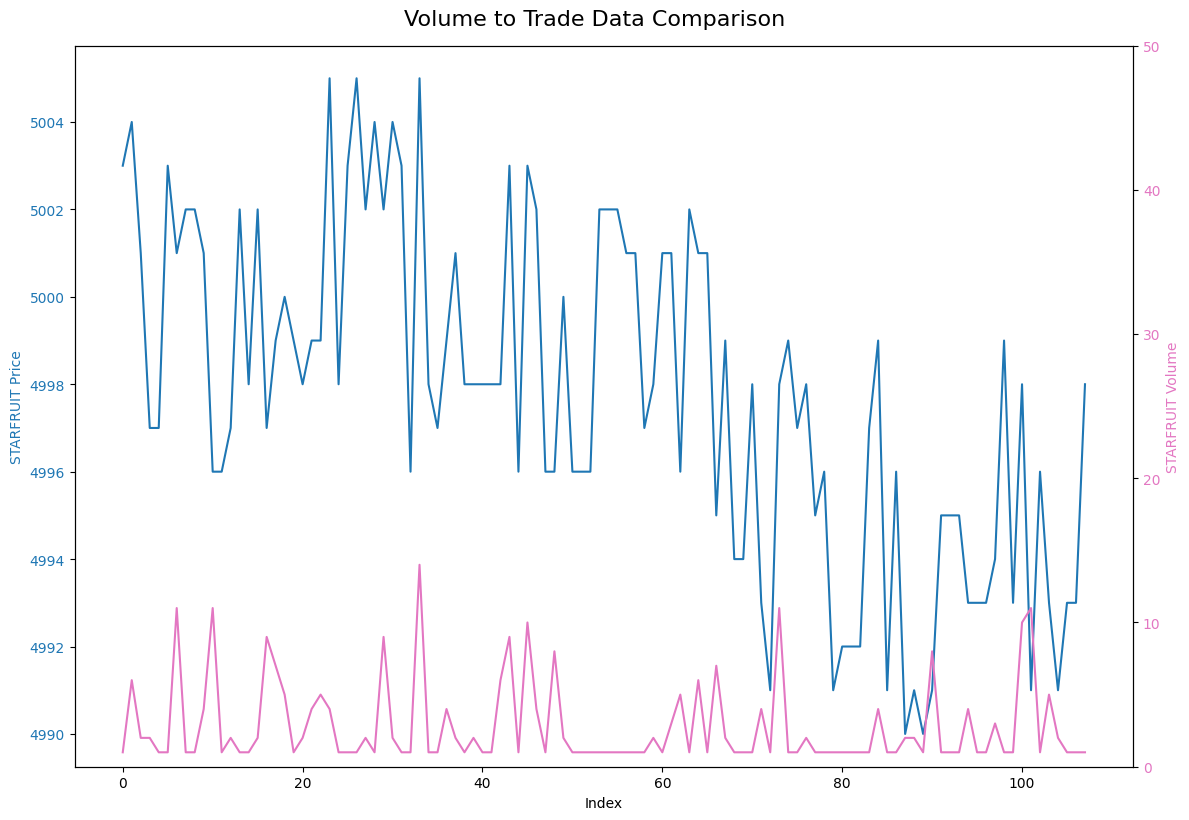

In [24]:
plot_trade_volume_vs_price("STARFRUIT", trades_data[:200])

In [25]:
starfruit_product = trades_data.loc[trades_data['symbol'] == "STARFRUIT", ['timestamp','price', 'quantity']]

# Group by 'timestamp' and 'symbol', then sum the 'quantity'
aggregated_df = starfruit_product.groupby(['timestamp', 'price']).agg({'quantity': 'sum'}).reset_index()

print(aggregated_df['price'].pct_change().corr(aggregated_df['quantity'])) # correlation between returns and quantity
print(aggregated_df['quantity'].corr(aggregated_df['price'])) # correlation between price and quantity

0.051855196665046455
0.02226421416830194


In [ ]:
import quantstats as qs

qs.extend_pandas()

# Assuming 'price' is the column with asset prices, we convert it to returns
returns = amethyst['mid_price'].pct_change().dropna()

# Plotting the return distribution
qs.plots.distribution(returns, figsize=(10, 6))

# Plotting the rolling drawdown
qs.plots.drawdown(returns, figsize=(10, 6))

# Plotting the cumulative returns
qs.plots.cum_returns(returns, figsize=(10, 6))

### Stationarity Check

In [26]:
from statsmodels.tsa.stattools import coint, adfuller

amethyst = price_data[price_data["product"] == "AMETHYSTS"]
amethyst_first_diff = amethyst['mid_price'].dropna().diff()[1:]
print(amethyst_first_diff.head())
print(adfuller(amethyst_first_diff)[1]) # makes sense as the price is literally stationary

2     2.5
5    -2.5
6     0.0
8    -3.5
10    3.5
Name: mid_price, dtype: float64
0.0


In [27]:
starfruit = price_data[price_data["product"] == "STARFRUIT"]
starfruit_first_diff = starfruit['mid_price'].dropna().pct_change()[1:]
print(starfruit_first_diff.head())
print(adfuller(starfruit_first_diff))

3     0.0004
4    -0.0004
7    -0.0001
9    -0.0002
11    0.0007
Name: mid_price, dtype: float64
(-66.8798690369273, 0.0, 10, 29988, {'1%': -3.43056808256121, '5%': -2.861636386595783, '10%': -2.5668213036438177}, -406150.8292260655)


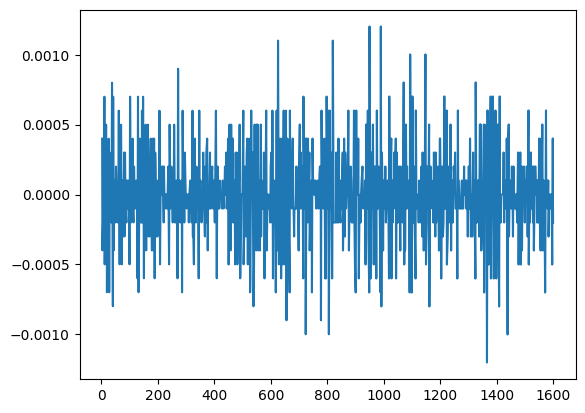

In [28]:
plt.plot(starfruit_first_diff[:800])
plt.show()

In [29]:
starfruit_avg = np.average(starfruit['mid_price'])
print(starfruit_avg)


5037.425666666667


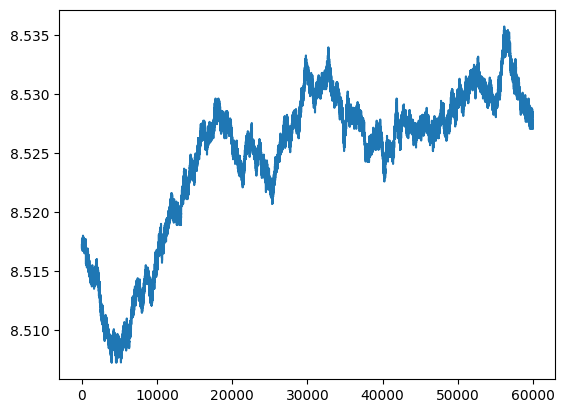

In [30]:
starfruit_lognormal =  np.log(starfruit['mid_price'])
plt.plot(starfruit_lognormal)
plt.show()

### ARIMA
- basic ARIMA to predict returns

In [31]:
from statsmodels.tsa.arima.model import ARIMA

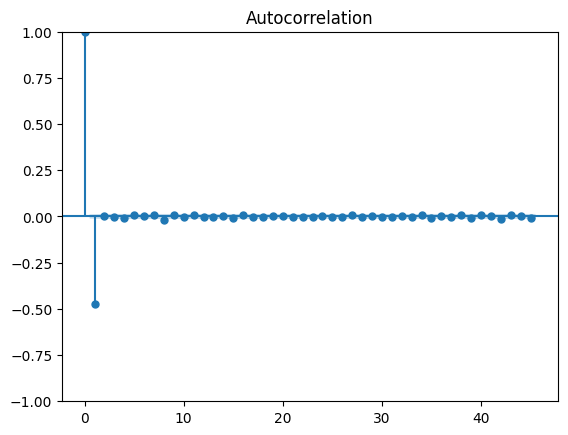

[]

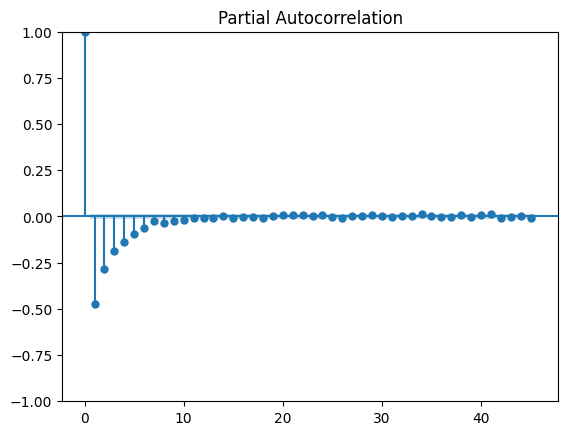

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(starfruit_first_diff)
plt.show()
plot_pacf(starfruit_first_diff)
plt.plot()

In [33]:
model = ARIMA(starfruit['mid_price'][:100], order=(1, 1, 1)) # 1 and 1 for PACF/ACF for now

# Fit the ARIMA model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              mid_price   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -169.870
Date:                Wed, 10 Apr 2024   AIC                            345.740
Time:                        15:22:30   BIC                            353.525
Sample:                             0   HQIC                           348.890
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0375      0.114      0.330      0.741      -0.185       0.260
ma.L1         -0.9407      0.038    -24.702      0.000      -1.015      -0.866
sigma2         1.7730      0.280      6.340      0.0

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RangeIndex(start=100, stop=110, step=1)


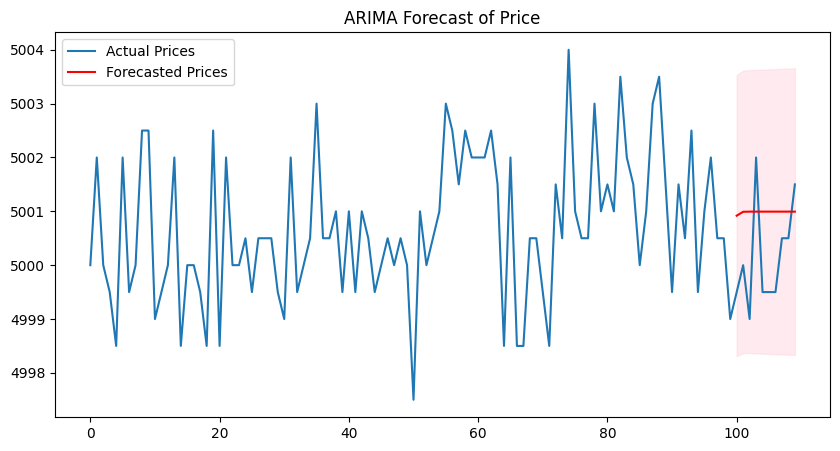

In [34]:
# Forecast future prices
# The 'typ' parameter is set to 'levels' to predict the actual price levels rather than differences
forecast = model_fit.get_forecast(steps=10)
predicted_prices = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(predicted_prices.index)

# Plot the price data and the forecast with confidence intervals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
starfruit = starfruit.reset_index(drop=True)
plt.plot(starfruit['mid_price'][:110], label='Actual Prices')
plt.plot(predicted_prices, label='Forecasted Prices', color='red')
plt.fill_between(predicted_prices.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Price')
plt.legend()
plt.show()